In [2]:
import numpy as np
import pandas as pd

from tqdm import tqdm

import sbmlcore
import sbmlsim
import gumpy

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload

%autoreload 2


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# some of the resistant mutations are from mutagenesis studies (yaddon)
# train/test set was constructed from lists of mutations from yaddon and 2x catalogues, with conflicts removed
# not constructed from real data
# for simple ML paper, validation set was created from cryptic with 'football score' method

# can either try with cryptic real data (either all of the samples, or pick the unique alleles [ie. where there are no conflicts])
# or can do like for like comparison, with created dataset like in simple ML paper

# TODO: construct alleles from MUTATIONS table
# be aware of uniqueID; if multiple rows have the same uniqueID, then there are multiple mutations in the same allele
# can't use promoters, indels etc. (for now?). and get rid of filter fails
# think carefully about how to build the alleles^^ 

- Limit Mutations table to:
    - Remove promoter mutations
    - Remove indels
    - Remove premature STOPs
    - Remove filter fails
    - Remove IS_NULLs (where base didn't reach FRS threshold?)
- Get phenotype labels from DST
- Generate alleles
    - Samples with multiple mutations put together
- Deduplicate
    - Should leave one WT allele (from the synonymous mutations)
    - Remove?

In [4]:
# import os
# os.path.relpath(os.getcwd(), 'data')

GENOMES = pd.read_pickle('../data/GENOMES.pkl.gz')
MUTATIONS = pd.read_pickle('../data/MUTATIONS-pncA.pkl.gz')
DST = pd.read_pickle('../data/DST-PZA.pkl.gz')

MUTATIONS.set_index([MUTATIONS.index, 'MUTATION'], inplace=True)

In [5]:
print('Number of rows in pnca mutations table:', len(MUTATIONS))
print('Number of unique alleles:', MUTATIONS.index.get_level_values(0).nunique())

Number of rows in pnca mutations table: 36790
Number of unique alleles: 22266


### Limit Mutations table

In [6]:
MUTATIONS.columns

Index(['GENE', 'POSITION', 'AMINO_ACID_NUMBER', 'GENOME_INDEX',
       'NUCLEOTIDE_NUMBER', 'REF', 'ALT', 'IS_SNP', 'IS_INDEL', 'IN_CDS',
       'IN_PROMOTER', 'IS_SYNONYMOUS', 'IS_NONSYNONYMOUS', 'IS_HET', 'IS_NULL',
       'IS_FILTER_PASS', 'ELEMENT_TYPE', 'MUTATION_TYPE', 'INDEL_LENGTH',
       'INDEL_1', 'INDEL_2', 'SITEID', 'NUMBER_NUCLEOTIDE_CHANGES'],
      dtype='object')

In [7]:
MUTATIONS = MUTATIONS[MUTATIONS.IN_PROMOTER == False]
MUTATIONS = MUTATIONS[MUTATIONS.IS_INDEL == False]
MUTATIONS = MUTATIONS[~MUTATIONS.index.get_level_values('MUTATION').str.endswith('!')]
MUTATIONS = MUTATIONS[MUTATIONS.IS_FILTER_PASS == True]
MUTATIONS = MUTATIONS[MUTATIONS.IS_NULL == False]
MUTATIONS = MUTATIONS[MUTATIONS.IS_SYNONYMOUS == False]

In [8]:
# New counts

print('Number of rows in pnca mutations table:', len(MUTATIONS))
print('Number of unique alleles:', MUTATIONS.index.get_level_values(0).nunique())

Number of rows in pnca mutations table: 10883
Number of unique alleles: 10737


### Get phenotype labels

In [9]:
DST.PHENOTYPE.value_counts()

PHENOTYPE
S    18804
R     3339
Name: count, dtype: int64

In [10]:
MUTATIONS = MUTATIONS.merge(DST['PHENOTYPE'], left_index=True, right_index=True, how='inner')
MUTATIONS

,,GENE,POSITION,AMINO_ACID_NUMBER,GENOME_INDEX,NUCLEOTIDE_NUMBER,REF,ALT,IS_SNP,IS_INDEL,IN_CDS,...,IS_NULL,IS_FILTER_PASS,ELEMENT_TYPE,MUTATION_TYPE,INDEL_LENGTH,INDEL_1,INDEL_2,SITEID,NUMBER_NUCLEOTIDE_CHANGES,PHENOTYPE
UNIQUEID,MUTATION,,,,,,,,,,,,,,,,,,,,,
site.05.subj.PSLM-0791.lab.SLM-049.iso.1,L120P,pncA,120.0,120.0,NaN,NaN,ctg,ccg,True,False,True,...,False,True,GENE,AAM,NaN,,,05,1,R
site.05.subj.LR-2032.lab.FN-00407-15.iso.1,W119L,pncA,119.0,119.0,NaN,NaN,tgg,ttg,True,False,True,...,False,True,GENE,AAM,NaN,,,05,1,R
site.05.subj.PMK-1015.lab.MK-1781.iso.1,F58L,pncA,58.0,58.0,NaN,NaN,ttc,ctc,True,False,True,...,False,True,GENE,AAM,NaN,,,05,1,S
site.05.subj.LR-2417.lab.FN-01304-17.iso.1,H51R,pncA,51.0,51.0,NaN,NaN,cac,cgc,True,False,True,...,False,True,GENE,AAM,NaN,,,05,1,R
site.05.subj.LR-2162.lab.FN-00284-16.iso.1,V139L,pncA,139.0,139.0,NaN,NaN,gtg,ctg,True,False,True,...,False,True,GENE,AAM,NaN,,,05,1,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
site.10.subj.SAPA00070896_S17.lab.PA00070896_S17.iso.1,G97D,pncA,97.0,97.0,NaN,NaN,ggt,gat,True,False,True,...,False,True,GENE,AAM,NaN,,,10,1,R
site.10.subj.UH01142796.lab.UH01142796.iso.1,C14R,pncA,14.0,14.0,NaN,NaN,tgc,cgc,True,False,True,...,False,True,GENE,AAM,NaN,,,10,1,R
site.10.subj.SADG00497215_S8.lab.DG00497215_S8.iso.1,C138R,pncA,138.0,138.0,NaN,NaN,tgt,cgt,True,False,True,...,False,True,GENE,AAM,NaN,,,10,1,R


In [11]:
# New counts

print('Number of rows in pnca mutations table:', len(MUTATIONS))
print('Number of unique alleles:', MUTATIONS.index.get_level_values(0).nunique())

Number of rows in pnca mutations table: 2847
Number of unique alleles: 2832


### Generate Alleles

In [12]:
reference = gumpy.Genome('../data/NC_000962.3.gbk')

pnca = reference.build_gene('pncA')

wt_seq = ''.join([aa for aa in pnca.amino_acid_sequence])
wt_seq

'MRALIIVDVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVATKDFHIDPGDHFSGTPDYSSSWPPHCVSGTPGADFHPSLDTSAIEAVFYKGAYTGAYSGFEGVDENGTPLLNWLRQRGVDEVDVVGIATDHCVRQTAEDAVRNGLATRVLVDLTAGVSADTTVAALEEMRTASVELVCSS!'

In [13]:
# alleles = pd.DataFrame(columns=['allele', 'number_resistant_mutations', 'number_susceptible_mutations', 'phenotype_label'])
alleles = pd.DataFrame(columns=['allele', 'number_mutations', 'phenotype_label'])

for sample in MUTATIONS.index.get_level_values('UNIQUEID'):
    allele_muts = MUTATIONS.xs(sample, level = 0)
    # if len(allele_muts) == 1:
    #     continue
    positions = allele_muts.POSITION.values
    positions = [int(pos) -1 for pos in positions]
    
    seq = pnca.amino_acid_sequence.copy()
    
    for indx, pos in enumerate(positions):
        # print(pos)
        # print(wt_seq[pos])
        # print(allele_muts.index[indx][0])
        
        # if wt_seq[pos] != allele_muts.index[indx][0]:
        #     print(pos, wt_seq[pos], allele_muts.index[indx][0])
        
        assert wt_seq[pos] == allele_muts.index[indx][0], 'Mismatch between reference and mutation'

        seq[pos] = allele_muts.index[indx][-1]

    allele = ''.join([aa for aa in seq])
    num_mutations = len(allele_muts)
    phenotype = allele_muts['PHENOTYPE'].values[0]
    
    entry = pd.DataFrame([{
        'allele': allele,
        'number_mutations': num_mutations,
        'phenotype_label': phenotype
    }])
    
    # display(allele_muts)
    # break
    
    alleles = pd.concat([alleles, entry], ignore_index=True)

In [14]:
original_alleles = alleles.copy()

### Deduplicate

In [15]:
alleles.value_counts()

allele                                                                                                                                                                                       number_mutations  phenotype_label
MRALIIVDVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVATKDFHIDPGDDFSGTPDYSSSWPPHCVSGTPGADFHPSLDTSAIEAVFYKGAYTGAYSGFEGVDENGTPLLNWLRQRGVDEVDVVGIATDHCVRQTAEDAVRNGLATRVLVDLTAGVSADTTVAALEEMRTASVELVCSS!  1                 R                  228
MRALILVDVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVATKDFHIDPGDHFSGTPDYSSSWPPHCVSGTPGADFHPSLDTSAIEAVFYKGAYTGAYSGFEGVDENGTPLLNWLRQRGVDEVDVVGIATDHCVRQTAEDAVRNGLATRVLVDLTAGVSADTTVAALEEMRTASVELVCSS!  1                 S                  119
MRALIIVDVRNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVATKDFHIDPGDHFSGTPDYSSSWPPHCVSGTPGADFHPSLDTSAIEAVFYKGAYTGAYSGFEGVDENGTPLLNWLRQRGVDEVDVVGIATDHCVRQTAEDAVRNGLATRVLVDLTAGVSADTTVAALEEMRTASVELVCSS!  1                 R                   90
MRALIIVDVPNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVATKDFHIDPGDHFSGTPDYSSSWPPHCVSGTPGADFHPSLDT

In [16]:
alleles.drop_duplicates(inplace=True)

In [17]:
alleles.phenotype_label.value_counts()

phenotype_label
R    260
S    230
Name: count, dtype: int64

### Some alleles have both R and S phenotypes

In [18]:
repeated_alleles = alleles[alleles['allele'].duplicated(keep=False)]
unique_alleles = alleles[~alleles['allele'].duplicated(keep=False)]

repeated_alleles

,allele,number_mutations,phenotype_label
1,MRALIIVDVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVA...,1,R
2,MRALIIVDVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVA...,1,S
3,MRALIIVDVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVA...,1,R
4,MRALIIVDVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVA...,1,S
5,MRALIIVDVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVA...,1,R
...,...,...,...
2643,MRALIIVDVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVA...,1,S
2645,MRALIIVDVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVA...,1,S
2673,MRALIIVDVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVA...,1,S
2702,MRALIIVNVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVA...,1,S


In [19]:
repeated_list = repeated_alleles.allele.drop_duplicates().values

In [20]:
grouped_data = original_alleles[original_alleles['allele'].isin(repeated_list)].groupby(['allele', 'phenotype_label']).size()

# pd.DataFrame(grouped_data).rename(columns={0: 'count'}).sort_values('count', ascending=False).reset_index(drop=True)
conflict_df = pd.DataFrame(grouped_data).rename(columns={0: 'count'}).reset_index().set_index('allele', drop=True)
conflict_df

,phenotype_label,count
allele,,
MRALIIADVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVATKDFHIDPGDHFSGTPDYSSSWPPHCVSGTPGADFHPSLDTSAIEAVFYKGAYTGAYSGFEGVDENGTPLLNWLRQRGVDEVDVVGIATDHCVRQTAEDAVRNGLATRVLVDLTAGVSADTTVAALEEMRTASVELVCSS!,R,4
MRALIIADVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVATKDFHIDPGDHFSGTPDYSSSWPPHCVSGTPGADFHPSLDTSAIEAVFYKGAYTGAYSGFEGVDENGTPLLNWLRQRGVDEVDVVGIATDHCVRQTAEDAVRNGLATRVLVDLTAGVSADTTVAALEEMRTASVELVCSS!,S,1
MRALIIFDVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVATKDFHIDPGDHFSGTPDYSSSWPPHCVSGTPGADFHPSLDTSAIEAVFYKGAYTGAYSGFEGVDENGTPLLNWLRQRGVDEVDVVGIATDHCVRQTAEDAVRNGLATRVLVDLTAGVSADTTVAALEEMRTASVELVCSS!,R,2
MRALIIFDVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVATKDFHIDPGDHFSGTPDYSSSWPPHCVSGTPGADFHPSLDTSAIEAVFYKGAYTGAYSGFEGVDENGTPLLNWLRQRGVDEVDVVGIATDHCVRQTAEDAVRNGLATRVLVDLTAGVSADTTVAALEEMRTASVELVCSS!,S,1
MRALIIGDVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVATKDFHIDPGDHFSGTPDYSSSWPPHCVSGTPGADFHPSLDTSAIEAVFYKGAYTGAYSGFEGVDENGTPLLNWLRQRGVDEVDVVGIATDHCVRQTAEDAVRNGLATRVLVDLTAGVSADTTVAALEEMRTASVELVCSS!,R,31
...,...,...
MRALTIVDVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVATKDFHIDPGDHFSGTPDYSSSWPPHCVSGTPGADFHPSLDTSAIEAVFYKGAYTGAYSGFEGVDENGTPLLNWLRQRGVDEVDVVGIATDHCVRQTAEDAVRNGLATRVLVDLTAGVSADTTVAALEEMRTASVELVCSS!,S,2
MRASIIVDVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVATKDFHIDPGDHFSGTPDYSSSWPPHCVSGTPGADFHPSLDTSAIEAVFYKGAYTGAYSGFEGVDENGTPLLNWLRQRGVDEVDVVGIATDHCVRQTAEDAVRNGLATRVLVDLTAGVSADTTVAALEEMRTASVELVCSS!,R,38
MRASIIVDVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVATKDFHIDPGDHFSGTPDYSSSWPPHCVSGTPGADFHPSLDTSAIEAVFYKGAYTGAYSGFEGVDENGTPLLNWLRQRGVDEVDVVGIATDHCVRQTAEDAVRNGLATRVLVDLTAGVSADTTVAALEEMRTASVELVCSS!,S,9


In [21]:
r_counts = conflict_df[conflict_df['phenotype_label'] == 'R']
r_counts['count'] = r_counts['count'] *-1

s_counts = conflict_df[conflict_df['phenotype_label'] == 'S']

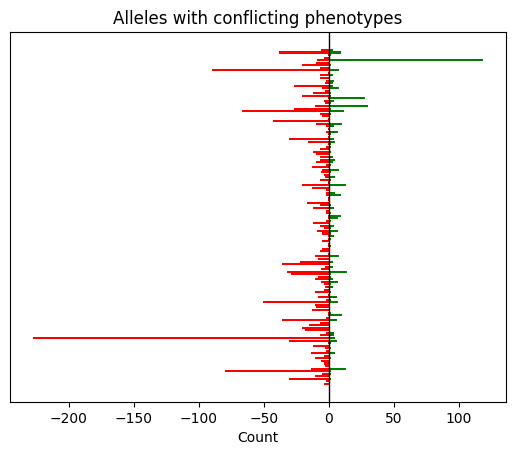

In [22]:
import matplotlib.pyplot as plt

# Data
categories = (list(r_counts.index)) + (list(s_counts.index))
values = np.concatenate((r_counts['count'].values, s_counts['count'].values))

# Create a figure and axis
fig, ax = plt.subplots()

# Create a horizontal bar chart
ax.barh(categories, values, color=['red' if v < 0 else 'green' for v in values])

# Add a vertical line at x=0
ax.axvline(0, color='black', linewidth=1)

# Labels and Title
ax.set_xlabel('Count')
ax.set_title('Alleles with conflicting phenotypes')


plt.yticks([], [])

plt.show()


In [23]:
resolved_phen_df = conflict_df.pivot_table(index='allele', columns='phenotype_label', values='count').astype(int)
resolved_phen_df.rename_axis(None, axis=1, inplace=True)
resolved_phen_df['total'] = resolved_phen_df.sum(axis=1)

In [24]:
def phen_resolve(row):
    prop_r = row['R'] / row['total']
    prop_s = row['S'] / row['total']
    phenotype_res = 'R' if prop_r >= 0.8 else 'S' if prop_s >= 0.8 else 'U'
    return phenotype_res

resolved_phen_df['phenotype_label'] = resolved_phen_df.apply(phen_resolve, axis=1)

In [25]:
resolved_phen_df

,R,S,total,phenotype_label
allele,,,,
MRALIIADVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVATKDFHIDPGDHFSGTPDYSSSWPPHCVSGTPGADFHPSLDTSAIEAVFYKGAYTGAYSGFEGVDENGTPLLNWLRQRGVDEVDVVGIATDHCVRQTAEDAVRNGLATRVLVDLTAGVSADTTVAALEEMRTASVELVCSS!,4,1,5,R
MRALIIFDVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVATKDFHIDPGDHFSGTPDYSSSWPPHCVSGTPGADFHPSLDTSAIEAVFYKGAYTGAYSGFEGVDENGTPLLNWLRQRGVDEVDVVGIATDHCVRQTAEDAVRNGLATRVLVDLTAGVSADTTVAALEEMRTASVELVCSS!,2,1,3,U
MRALIIGDVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVATKDFHIDPGDHFSGTPDYSSSWPPHCVSGTPGADFHPSLDTSAIEAVFYKGAYTGAYSGFEGVDENGTPLLNWLRQRGVDEVDVVGIATDHCVRQTAEDAVRNGLATRVLVDLTAGVSADTTVAALEEMRTASVELVCSS!,31,2,33,R
MRALIILDVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVATKDFHIDPGDHFSGTPDYSSSWPPHCVSGTPGADFHPSLDTSAIEAVFYKGAYTGAYSGFEGVDENGTPLLNWLRQRGVDEVDVVGIATDHCVRQTAEDAVRNGLATRVLVDLTAGVSADTTVAALEEMRTASVELVCSS!,11,1,12,R
MRALIIVDGQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVATKDFHIDPGDHFSGTPDYSSSWPPHCVSGTPGADFHPSLDTSAIEAVFYKGAYTGAYSGFEGVDENGTPLLNWLRQRGVDEVDVVGIATDHCVRQTAEDAVRNGLATRVLVDLTAGVSADTTVAALEEMRTASVELVCSS!,5,2,7,U
...,...,...,...,...
MRALILVDVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVATKDFHIDPGDHFSGTPDYSSSWPPHCVSGTPGADFHPSLDTSAIEAVFYKGAYTGAYSGFEGVDENGTPLLNWLRQRGVDEVDVVGIATDHCVRQTAEDAVRNGLATRVLVDLTAGVSADTTVAALEEMRTASVELVCSS!,9,119,128,S
MRALSIVDVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVATKDFHIDPGDHFSGTPDYSSSWPPHCVSGTPGADFHPSLDTSAIEAVFYKGAYTGAYSGFEGVDENGTPLLNWLRQRGVDEVDVVGIATDHCVRQTAEDAVRNGLATRVLVDLTAGVSADTTVAALEEMRTASVELVCSS!,4,1,5,R
MRALTIVDVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVATKDFHIDPGDHFSGTPDYSSSWPPHCVSGTPGADFHPSLDTSAIEAVFYKGAYTGAYSGFEGVDENGTPLLNWLRQRGVDEVDVVGIATDHCVRQTAEDAVRNGLATRVLVDLTAGVSADTTVAALEEMRTASVELVCSS!,1,2,3,U


In [26]:
resolved_phen_df.phenotype_label.value_counts()

phenotype_label
U    71
R    54
S     7
Name: count, dtype: int64

### Add back alleles with resolved phenotype

`unique_alleles` + `resolved_phen_df` (without U's)

In [27]:
alles_to_add = resolved_phen_df[resolved_phen_df['phenotype_label'] != 'U'].reset_index()
alleles_to_add = repeated_alleles.merge(alles_to_add, on=['allele','phenotype_label'], how='inner')[['allele', 'number_mutations', 'phenotype_label']]
alleles_to_add

,allele,number_mutations,phenotype_label
0,MRALIIVDVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVA...,1,R
1,MRALIIVDVRNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVA...,1,R
2,MRALIIVDVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVA...,1,R
3,MRALIIVDVQNDFCEGGSLAVTGGAALARAISDDLAEAADYHHVVA...,1,R
4,MRALIIVDVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVA...,1,R
...,...,...,...
56,MRALIIADVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVA...,1,R
57,MRALIIVDVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVA...,1,S
58,MRALIIVDVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVA...,1,R
59,MRALSIVDVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVA...,1,R


In [28]:
final_alleles = pd.concat([unique_alleles, alleles_to_add]).reset_index(drop=True)

In [29]:
final_alleles.phenotype_label.value_counts()

phenotype_label
R    182
S    105
Name: count, dtype: int64

In [31]:
final_alleles

,allele,number_mutations,phenotype_label
0,MRALIIVDVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVA...,1,R
1,MRALIIVDVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVA...,1,R
2,MRALIIVDVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVA...,1,R
3,MRALIIVDVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVA...,1,R
4,MRALIIVDVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVA...,1,R
...,...,...,...
282,MRALIIADVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVA...,1,R
283,MRALIIVDVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVA...,1,S
284,MRALIIVDVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVA...,1,R
285,MRALSIVDVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVA...,1,R


In [32]:
final_alleles.to_csv('../data/cryptic_alleles.csv', index=False)

In [ ]:
"""  
things to try to see if model runs:
- try this dataset from CRyPTIC:
    - CRyPTIC samples where conflicts are resolved by being over 80% of one phenotype. Rest are removed
- exact train/test dataset from old pnca simple ML methods paper
"""
